## Install the neccesary packages

In [16]:
!pip install tensorflow matplotlib pandas numpy scikit-learn -q

## DataPreparation class

The objetive of the class is to analize and create a balance dataset from the root data that already has a train, test and validate sub-folders.

In [7]:
def preprocess_data(x, y):
    """
    This function handles the image vector and rescale it and optimize it

    :param x: (image dataset)
    :param y: (labels dataset)
    :return: x
    """
    output = tf.keras.layers.Rescaling(1. / 255)(x)
    return output, y

In [8]:
def prepare_dataset(dataset, training = False):
    """
    Receive the dataset and apply the corresponding preprocess.

    :param dataset
    """
    dataset = dataset.map(lambda x, y: preprocess_data(x, y))
    dataset = dataset.cache()
    if training:
        dataset = dataset.shuffle(3100)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

In [9]:
import tensorflow as tf
import logging
from pathlib import Path
from typing import Optional, Dict

logger = logging.getLogger(__name__)

class DataPreparation:
    """
    This class makes semi-automatic the creation of datasets.
    """
    def __init__(self,
                 root_folder,
                 img_size,
                 color_mode,
                 batch_size,
                 class_mode: str = 'binary',
                 shuffle: bool = True,
                 seed: Optional[int] = None,
                 validation_split: Optional[float] = None,
                 subset: Optional[str] = None,
                 cache: bool = True,
                 prefetch: bool = True,
                 recursive: bool = False):

        self.root_folder = root_folder
        self.img_size = img_size
        self.color_mode = color_mode
        self.batch_size = batch_size
        self.class_mode = class_mode
        self.shuffle = shuffle
        self.seed = seed
        self.validation_split = validation_split
        self.subset = subset
        self.cache = cache
        self.prefetch = prefetch
        self.recursive = recursive

    def create_datasets_from_subdirectories(self) -> Dict[str, tf.data.Dataset]:
        root = Path(self.root_folder)
        if not root.exists():
            logger.error("Root folder does not exist: %s", self.root_folder)
            raise FileNotFoundError(f"Root folder does not exist: {self.root_folder}")

        subdirectories = [p for p in root.iterdir() if p.is_dir()]
        datasets = {}
        if not subdirectories:
            try:
                ds = self.create_dataset(str(root))
                datasets[root.name] = ds
                logger.info("Loaded single dataset from root folder.")
            except Exception as e:
                logger.exception("Failed to load dataset from root folder: %s", e)
            return datasets

        for sub in subdirectories:
            path = str(sub)
            try:
                ds = self.create_dataset(path)
                datasets[sub.name] = ds
            except Exception as e:
                logger.exception("Skipping dataset at %s due to error: %s", path, e)

        logger.info('Data normalization done!')
        return datasets

    def create_dataset(self, path: str) -> tf.data.Dataset:
        p = Path(path)
        class_dirs = [d for d in p.iterdir() if d.is_dir() and any(f for f in d.rglob('*') if f.is_file())]
        classes_count = len(class_dirs)

        label_mode = self.class_mode
        if classes_count == 0:
            label_mode = None
            logger.info("No class subdirectories found in %s — using label_mode=None", path)
        else:
            if self.class_mode == 'binary' and classes_count != 2:
                label_mode = 'categorical'
                logger.info("class_mode='binary' but %d classes found in %s — switching to 'categorical'", classes_count, path)

        try:
            dataset = tf.keras.utils.image_dataset_from_directory(
                directory=path,
                image_size=self.img_size,
                color_mode=self.color_mode,
                batch_size=self.batch_size,
                label_mode=label_mode,
                shuffle=self.shuffle,
                seed=self.seed,
                validation_split=self.validation_split,
                subset=self.subset,
                follow_links=self.recursive
            )
            logger.info('Dataset loaded successfully from %s', path)
            logger.info('Classes found in dataset: %s', getattr(dataset, 'class_names', None))
        except Exception as e:
            logger.exception("Error loading dataset from %s: %s", path, e)
            raise

        try:
            is_training = 'train' in path.lower()
            dataset = prepare_dataset(dataset, training=is_training) if is_training else prepare_dataset(dataset)
        except Exception:
            logger.exception("prepare_dataset failed for %s, returning raw dataset", path)

        try:
            if self.cache:
                dataset = dataset.cache()
            if self.prefetch:
                dataset = dataset.prefetch(tf.data.AUTOTUNE)
        except Exception:
            logger.exception("Error applying cache/prefetch for %s — returning dataset without those optimizations", path)

        return dataset

## Base Model and Sub-Models Architecture

This project is designed with a specific architectural vision in mind: to leverage the strengths of different deep learning models through an ensemble approach. The core idea is to create various models, each based on a distinct architecture (such as ResNet, Inception, MobileNet, etc.), but all sharing a common foundation. By combining the predictions of these diverse models, we aim to achieve a more robust and accurate overall prediction than any single model could achieve on its own.

Here's a breakdown of the planned classes:

*   **Base Model Class:** This serves as the foundational class for all other model instances. It will contain the basic functionalities and parameters common to all models, such as methods for compiling the model, training, evaluation, and potentially saving/loading weights. The other model-specific classes will inherit from this Base Model class, ensuring a consistent interface and reducing code duplication. This class defines the core structure and shared logic for handling the models.

*   **EfficientNetV2Instance Class:** This class will inherit from the `Base Model` class. It will specifically implement a model based on the EfficientNetV2 architecture. EfficientNetV2 is known for its good balance between accuracy and efficiency, making it a suitable choice for one of the ensemble members.

*   **MobileNetV2Instance Class:** This class will also inherit from the `Base Model` class. It will implement a model based on the MobileNetV2 architecture. MobileNetV2 is optimized for mobile and embedded vision applications, focusing on computational efficiency and low latency. Including it in the ensemble brings diversity in terms of model complexity and performance characteristics.

*   **ResNet50V2Instance Class:** Another class inheriting from the `Base Model`. This one will implement a model using the ResNet50V2 architecture. ResNet (Residual Networks) are famous for their ability to train very deep networks effectively, and ResNet50V2 is a widely used variant known for its strong performance on image classification tasks.

The ultimate goal is to take advantage of the unique features and learning capabilities of each individual architecture (EfficientNetV2, MobileNetV2, ResNet50V2, etc.) through the ensemble method. This approach allows the project to explore how different model perspectives can be combined to improve the overall performance in classifying benign or malignant cancer in images.


### Base model

In [34]:
from tensorflow import keras
from typing import Union, Optional

In [35]:
def image_augmentation(x):

    x = keras.layers.RandomFlip('horizontal')(x)
    x = keras.layers.RandomRotation(0.1)(x)
    x = keras.layers.RandomZoom(0.1)(x)
    x = keras.layers.RandomTranslation(0.2, 0.2)(x)
    x = keras.layers.RandomContrast(0.2)(x)
    return x

In [36]:
from ast import Raise
from typing import Union, Optional

from tensorflow import keras

class BaseModel:

    def __init__(self,
                 model: Optional[keras.Model] = None,
                 optimizer: Optional[Union[str, keras.optimizers.Optimizer]] = None,
                 loss: Optional[Union[str, keras.losses.Loss]] = None,
                 metrics: Optional[Union[list[Union[str, keras.metrics.Metric]]]] = None,
                 epochs: Optional[int] = None,
                 learning_rate: Optional[float] = None,
                 train_dataset: Optional[object] = None,
                 test_dataset: Optional[object] = None,
                 validation_dataset: Optional[object] = None,
                 task_type: Optional[str] = None,
                 debug: Optional[bool] = None,
                 img_shape: Optional[tuple] = False,
                 layer_name: Optional[str] = None,
                 name: Optional[str] = None
                 ):

        self.model = model
        self.optimizer = optimizer or keras.optimizers.Adam(learning_rate=0.001)
        self.metrics = metrics or ['accuracy']
        self.loss = loss
        self.train_dataset = train_dataset
        self.test_dataset = test_dataset
        self.validation_dataset = validation_dataset
        self.learning_rate = 0.01
        self.task_type = task_type
        self.debug = False
        self.layer_name = layer_name
        self.units = None
        self.epochs = epochs or 20
        self.name = name

        match self.task_type:
            case 'binary':
                self.units = 1
            case 'categorical':
                self.units = 3

    def build_model(self, base_model):
        if base_model is None:
            raise ValueError("A base model must be provided.")

        for layer in base_model.layers:
            layer.trainable = False
            
        self.top_model(base_model=base_model)

    def top_model(self, base_model):
        inputs = keras.Input(
            shape=(224, 224, 3))
        x = image_augmentation(inputs)
        encoder_output = base_model(x, training=False)
        x = keras.layers.GlobalAveragePooling2D()(encoder_output)
        x = keras.layers.Dropout(0.5)(x)
        x = keras.layers.Dense(256)(x)
        x = keras.layers.BatchNormalization()(x)
        x = keras.layers.ReLU()(x)
        outputs = keras.layers.Dense(self.units, activation='sigmoid')(x)
        model = keras.Model(inputs=inputs, outputs=outputs)
        self.model = model

        for layer in self.model.layers:
            if isinstance(layer, keras.Model):
                for sublayer in layer.layers:
                    sublayer.trainable = False

    def compile(self, learning_rate=None):

        if learning_rate is None:
            optimizer = self.optimizer
        else:
            optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

        self.model.compile(
            optimizer=optimizer,
            loss=self.loss,
            metrics=self.metrics
        )

    def fit(self):
        if not hasattr(self, "callbacks") or not self.callbacks:
            raise RuntimeError("Callbacks must be set before training. Call set_callbacks() first.")

        if self.validation_dataset is not None:
            return self.model.fit(
                self.train_dataset,
                batch_size=32,
                epochs=self.epochs,
                validation_data=self.validation_dataset,
                callbacks=self.callbacks
            )
        else:
            return self.model.fit(
                self.train_dataset,
                batch_size=32,
                epochs=self.epochs,
                callbacks=self.callbacks
            )

    def set_callbacks(self,
                      filepath_to_save_model: str,
                      tensorboard_log_file: str,
                      monitor_param: Optional[str] = 'val_loss',
                      callbacks: list[keras.callbacks.Callback] = None,
                      early_stopping_patiencie: int = 10,
                      reducelr_patiente: int = 5,
                      factor: float = 0.5,
                      ):
        if early_stopping_patiencie <= reducelr_patiente:
            raise ('Early Stopping patience callback must have to be greater than'
                   'ReduceLROnPlateau patience callback')
        self.filepath_saved_model = filepath_to_save_model
        self.callbacks = callbacks or [
            keras.callbacks.EarlyStopping(
                patience=early_stopping_patiencie,
                monitor=monitor_param,
                restore_best_weights=True
            ),
            keras.callbacks.ModelCheckpoint(
                filepath=filepath_to_save_model,
                monitor=monitor_param,
                save_best_only=True
            ),
            keras.callbacks.ReduceLROnPlateau(
                patience=reducelr_patiente,
                monitor=monitor_param,
                factor=factor
            ),
            keras.callbacks.TensorBoard(
                log_dir=tensorboard_log_file,
                histogram_freq=1,
                write_images=True
            )
        ]

    def fine_tuning_model(self):
        model = self.model
        fine_tuning_at = self.get_index_from_layer(model=model)
        for layer in model.layers[:fine_tuning_at]:
            if isinstance(layer, keras.layers.BatchNormalization):
                layer.trainable = False
            else:
                layer.trainable = True

    def get_index_from_layer(self, model):
      index = -1
      layer_name = self.layer_name
        
      for _, layer in enumerate(model.layers):
        if layer.name == layer_name:
          index = _

      if index == -1:
        Raise(f"{layer_name} was not found in the layers while the fine tuning phase!")

      return index

    def execute_model_flow(self):
        """
            Execute the complete training workflow for transfer learning.
            The workflow consists of:
                1. Building the base transfer learning model.
                2. Compiling the model with the default optimizer.
                3. Performing initial training (feature extraction stage).
                4. Unfreezing selected layers for fine-tuning.
                5. Recompiling the model with a lower learning rate (1e-5).
                6. Training again (fine-tuning stage).

            :return: None
            :rtype: None
            """
        # Build model sets base_model trainable to False initially
        self.build_model()

        self.compile()
        print("\nStarting initial training (feature extraction)...")
        self.fit()
        print("\nFinished initial training successfully")
        # Directly pass self.layer_name to fine_tuning_model
        # fine_tuning_model will handle finding the index if it's a string
        start_layer_for_fine_tuning = self.layer_name if self.layer_name else None # Use layer_name if set

        if start_layer_for_fine_tuning:
            print(f"\nStarting fine-tuning from: {start_layer_for_fine_tuning}...")
            # Now call the modified fine_tuning_model with the determined starting layer (name or index)
            self.fine_tuning_model()
            # Only recompile and fit if fine-tuning was successfully initiated
            if any(layer.trainable for layer in self.model.layers): # Check if any layers were unfrozen
                 self.compile(learning_rate=1e-5) # Recompile with lower learning rate for fine-tuning
                 history = self.fit()
            else:
                 print("\nNo layers were unfrozen for fine-tuning. Skipping fine-tuning training stage.")
            return history
        else:
            print("\nSkipping fine-tuning as no starting layer name was specified in the constructor.")
            return None

### ResNet50V2

In [37]:
class ResNet50V2Instance(BaseModel):

    def __init__(self, *args, **kwargs):
        kwargs['loss'] = kwargs.get('loss', 'binary_crossentropy')
        super().__init__(*args, **kwargs)

        super().set_callbacks(
            filepath_to_save_model='model/saved_models/ResNet50V2Instance.keras',
            tensorboard_log_file='logs_dir/binary_model'
        )

    def build_model(self, model=None):
        if model is None:
            base_model = keras.applications.ResNet50V2(
                include_top=False,
                weights='imagenet',
                input_shape=(224, 224, 3)
            )
        else:
            base_model = model
        super().build_model(base_model=base_model)

### MobileNetV2

In [38]:
from tensorflow import keras
class MobileNetV2Instance(BaseModel):

    def __init__(self, *args, **kwargs):
        kwargs['loss'] = kwargs.get('loss', 'binary_crossentropy')
        kwargs['name'] = kwargs.get('name', 'MobileNetV2')
        kwargs['layer_name'] = kwargs.get('layer_name', 'block_14_expand')

        super().__init__(*args, **kwargs)

        super().set_callbacks(
            filepath_to_save_model='model/saved_models/MobileNetV2Instance.keras',
            tensorboard_log_file='logs_dir/binary_model'
        )

    def build_model(self, base_model=None):
        if base_model is None:
            base_model = keras.applications.MobileNetV2(
                include_top=False,
                weights='imagenet',
                input_shape=(224, 224, 3)
            )
        else:
            base_model = base_model
        super().build_model(base_model=base_model)

### EfficientNetV2


In [39]:
class EfficientNetV2Instance(BaseModel):
    def __init__(self, *args, **kwargs):
        kwargs['loss'] = kwargs.get('loss', 'binary_crossentropy')
        kwargs['name'] = kwargs.get('name', 'EfficientNetV2')
        kwargs['layer_name'] = kwargs.get('layer_name', 'block6a_expand_conv')
        super().__init__(*args, **kwargs)

        super().set_callbacks(
            filepath_to_save_model='model/saved_models/EfficientNetV2Instance.keras',
            tensorboard_log_file='logs_dir/binary_model'
        )

    def build_model(self, base_model=None):
        if base_model is None:
            base_model = keras.applications.ResNet50V2(
                include_top=False,
                weights='imagenet',
                input_shape=(224, 224, 3)
            )
        else:
            base_model = base_model
        super().build_model(base_model=base_model)

### RestNet50V2

In [40]:
class ResNet50V2Instance(BaseModel):

    def __init__(self, *args, **kwargs):
        kwargs['loss'] = kwargs.get('loss', 'binary_crossentropy')
        kwargs['name'] = kwargs.get('name', 'ResNet50V2')
        kwargs['layer_name'] = kwargs.get('layer_name', 'conv5_block1_preact_bn')
        super().__init__(*args, **kwargs)

        super().set_callbacks(
            filepath_to_save_model='model/saved_models/ResNet50V2Instance.keras',
            tensorboard_log_file='logs_dir/binary_model'
        )

    def build_model(self, model=None):
        if model is None:
            base_model = keras.applications.ResNet50V2(
                include_top=False,
                weights='imagenet',
                input_shape=(224, 224, 3)
            )
        else:
            base_model = model
        super().build_model(base_model=base_model)


### VitImageClassifier

This model comes from HugginFace transformers, transformers have powerful models such this one called TFVitModel.

This models use the technology from NLP in Computer Vision.

But first, tranformers library need to be installed.

In [ ]:
!pip install transformers

In [44]:
from transformers import TFViTModel, ViTFeatureExtractor

class ViTInstance(BaseModel):
    def __init__(self, *args, **kwargs):

        kwargs['loss'] = kwargs.get('loss', 'binary_crossentropy')
        kwargs['name'] = kwargs.get('name', 'ViTImageClassifier')
        kwargs['layer_name'] = kwargs.get('layer_name', 'transformer_block_10_layernorm')
        super().__init__(**kwargs)

        super().set_callbacks(
            filepath_to_save_model='model/saved_models/ViTImageClassifier.keras',
            tensorboard_log_file='logs_dir/binary_model'
        )

    def build_model(self, base_model=None):
        # 🔹 Cargamos el modelo ViT preentrenado
        try:
            if base_model is None:
                base_model = TFViTModel.from_pretrained("google/vit-base-patch16-224-in21k")
            else:
                base_model = base_model
    
            # 🔹 Congelamos los pesos (feature extraction)
            base_model.trainable = False
    
            # 🔹 Creamos la arquitectura de la parte superior (top layers)
            inputs = keras.Input(shape=(224, 224, 3), name="vit_input")
            x = keras.layers.Rescaling(1./255)(inputs)  # aseguramos normalización 0–1
    
            # ViT espera tensores en formato batch, height, width, channel
            outputs_vit = base_model(x, training=False).last_hidden_state
    
            # 🔹 Tomamos la salida del token [CLS] (posición 0)
            x = outputs_vit[:, 0, :]  # representación global
    
            # 🔹 Top model personalizado
            x = keras.layers.Dense(256, activation='relu')(x)
            x = keras.layers.Dropout(0.5)(x)
            outputs = keras.layers.Dense(self.units, activation='sigmoid')(x)
    
            self.model = keras.Model(inputs=inputs, outputs=outputs, name=self.name)
    
            print(f"{self.name} model built successfully ✅")
        except ModuleNotFoundError:
            print("There is an error with the libraries compatibility, please check the version of keras and transformers")


C:\Users\DFGOD\PycharmProjects\ClasificadorImagenesCancer\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### How to know since what layer start to unfreeze?

What it did was very simple, just take the model to inspect and see its layers, see the layer name where the last block begins and copy that name.

In [ ]:
def show_layers(model):
  for index, layer in enumerate(model.layers):
    print(f"{index}. {layer.name}")

def get_layer_by_name(model, layer_name):
  index = -1
  for _, layer in enumerate(model.layers):
    if layer.name == layer_name:
      index = _

  if index == -1:
    print(f"{layer_name} is not in layers")

  print(index)

model = keras.applications.MobileNetV2(
                include_top=False,
                weights='imagenet',
                input_shape=(224, 224, 3)
            )
show_layers(model=model)
#get_layer_by_name(model=model, layer_name='block_14_expand')

## Training the Models

With the updated `BaseModel` and its subclasses, the training process is streamlined, especially when using the `execute_model_flow` method.

1.  **Instantiate your desired model:** Create an instance of the specific model you want to train (e.g., `MobileNetV2Instance`, `ResNet50V2Instance`, `EfficientNetV2Instance`). When creating the instance, you can pass your training, testing, and validation datasets, as well as the `task_type` (`'binary'` or `'categorical'`). You can also specify the `layer_name` in the constructor to define the starting point for fine-tuning during the `execute_model_flow`.

### Create the datasets

In [10]:
from pathlib import Path

dataset = DataPreparation(
        root_folder='data', # Path from where the images are (train, test, validation)
        img_size=(224, 224), # Width and height to work with images (a greater scale of pixeles required a better GPU)
        color_mode='rgb', # Color mode from each image (RGB = color, gray = no color)
        batch_size=32,
        class_mode='binary',
        shuffle=True).create_datasets_from_subdirectories()

Found 392 files belonging to 2 classes.
Found 3126 files belonging to 2 classes.
Found 390 files belonging to 2 classes.


In [42]:
from enum import Enum

class TaskType(Enum):
    BINARY = "binary"
    CATEGORICAL = "categorical"
    REGRESSION = "regression"

### Create instances from each model

In [45]:
from tensorflow.keras.metrics import Precision, Recall, AUC, F1Score, BinaryAccuracy

metrics = [
    Precision(name="precision"),
    Recall(name="recall"),
    AUC(name="auc"),
    F1Score(name="f1_score", threshold=0.5, average='micro'),
    BinaryAccuracy(name="accuracy")
]

mobilenet_model = MobileNetV2Instance(
    train_dataset=dataset['train'],        # Use the training dataset from DataPreparation
    validation_dataset=dataset['validation'],   # Use the validation dataset from DataPreparation
    test_dataset=dataset['test'],         # Use the test dataset from DataPreparation
    task_type=TaskType.BINARY.value,        # Or 'categorical' depending on your problem
    layer_name='block_15_expand',
    epochs=20,
    metrics=metrics
)

efficientnet_model = EfficientNetV2Instance(
    train_dataset=dataset['train'],        # Use the training dataset from DataPreparation
    validation_dataset=dataset['validation'],   # Use the validation dataset from DataPreparation
    test_dataset=dataset['test'],         # Use the test dataset from DataPreparation
    task_type=TaskType.BINARY.value,        # Or 'categorical' depending on your problem
    layer_name='block6a_expand_conv',
    epochs=20,
    metrics=metrics
)

resnet_model = ResNet50V2Instance(
    train_dataset=dataset['train'],        # Use the training dataset from DataPreparation
    validation_dataset=dataset['validation'],   # Use the validation dataset from DataPreparation
    test_dataset=dataset['test'],         # Use the test dataset from DataPreparation
    task_type=TaskType.BINARY.value,        # Or 'categorical' depending on your problem
    layer_name='conv5_block1_preact_bn',
    epochs=20,
    metrics=metrics
)

vitclassifier_model = ViTInstance(
    train_dataset=dataset['train'],        # Use the training dataset from DataPreparation
    validation_dataset=dataset['validation'],   # Use the validation dataset from DataPreparation
    test_dataset=dataset['test'],         # Use the test dataset from DataPreparation
    task_type=TaskType.BINARY.value,        # Or 'categorical' depending on your problem
    layer_name='conv5_block1_preact_bn',
    epochs=2,
    metrics=metrics
)


### Create a flow to train each model and save it

When already have the instances, we need to train each model and save each model as a .keras file.
If each instance is train and save it correctly, the following phase is evaluate, think if we need more precision or recall in the model and do a litte bit of hyperparameter tuning.

In [46]:
def show_menu():
    available_models = [mobilenet_model, efficientnet_model, resnet_model]
    selection = int(input("""Please select the choice you need
    1. Train all the models # In case you have never trained a model before
    2. Train a select model # In case you need to re-trained a specific model again
    """))
    match selection:
        case 1:
            return train_each_model(available_models=available_models)
        case 2:
            train_individual_model(available_models=available_models)
            
def train_each_model(available_models: list[BaseModel]):
    if available_models is None:
        raise "Available models is empty, please check for some problem."

    saved_models_path = {}
    
    if isinstance(available_models, list):
        for model in available_models:
            model_name = model.name
            print(f"Training the {model_name} model")
            model.execute_model_flow()
            saved_models_path[model.name] = model.filepath_saved_model
            print(f"Finished the training {model_name} model successfully")

    print(f"""
    The models have been trained and saved successfully!
    The saved models paths are:
    {[f"{name}: {path}" for name, path in saved_models_path.items()]}
    """)
    return saved_models_path

def train_individual_model(available_models):
    selection = int(input("""Please select the model to train
    0. MobileNetV2
    1. EfficientNetV2
    3. ResNetV2
    """))

    model = available_models[selection]
    model_name = model.name
    
    print(f"Training the {model_name} model")
    model.execute_model_flow()
    print(f"Finished the training {model_name} model successfully")

    print(f"Model saved in the follow path {model.filepath_saved_model}")


saved_models_path = show_menu()

Please select the choice you need
    1. Train all the models # In case you have never trained a model before
    2. Train a select model # In case you need to re-trained a specific model again
     1


Training the MobileNetV2 model

Starting initial training (feature extraction)...
Epoch 1/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 54s 473ms/step - accuracy: 0.6993 - auc: 0.7613 - f1_score: 0.7022 - loss: 0.6142 - precision: 0.6955 - recall: 0.7089 - val_accuracy: 0.7538 - val_auc: 0.8372 - val_f1_score: 0.7983 - val_loss: 0.5814 - val_precision: 0.6762 - val_recall: 0.9744 - learning_rate: 0.0010
Epoch 2/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 54s 548ms/step - accuracy: 0.7214 - auc: 0.7956 - f1_score: 0.7220 - loss: 0.5607 - precision: 0.7204 - recall: 0.7236 - val_accuracy: 0.7718 - val_auc: 0.8549 - val_f1_score: 0.7652 - val_loss: 0.4711 - val_precision: 0.7880 - val_recall: 0.7436 - learning_rate: 0.0010
Epoch 3/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 52s 527ms/step - accuracy: 0.7425 - auc: 0.8148 - f1_score: 0.7448 - loss: 0.5316 - precision: 0.7381 - recall: 0.7518 - val_accuracy: 0.8000 - val_auc: 0.8606 - val_f1_score: 0.8050 - val_loss: 0.4567 - val_precision: 0.7854 - val_recall: 0.8256 - learning_rate

## Load and evaluate the models

In [1]:
from keras.models import load_model

mobilenet_model = load_model('model/saved_models/MobileNetV2Instance.keras')
efficiennet_model = load_model('model/saved_models/EfficientNetV2Instance.keras')
resnet_model = load_model('model/saved_models/ResNet50V2Instance.keras')

### Y prediction probability and Y true

y_pred_prob variable are the probability of the prediction from being a benign or malign cancer. All the three models has just 1 unit and sigmoid activation, so the probability is telling how much procentage the prediction is the positive class (malign cancer).

y_true variable are the true answers for each image that the model predicted.

As an example, if we take the first array from both y_pred and y_true variables:

y_pred_proba = 0.08757259

y_true = 0

It means that the first image has just only 8.75% from being a melign cancer, and looking for the true label it's right, the true label tell that the first image is non-malign (class 0). 

In [8]:
import numpy as np
y_pred_proba = mobilenet_model.predict(dataset['validation'])
y_true = np.concatenate([y for x, y in dataset['validation']], axis=0)
print(f'Y_pred:\n {y_pred_proba[:10]}')
print(f'Y_true:\n {y_true[:10]}')

13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 551ms/step
Y_pred:
 [[0.6621202 ]
 [0.07732461]
 [0.01473493]
 [0.7923487 ]
 [0.703632  ]
 [0.80637544]
 [0.2540691 ]
 [0.02138012]
 [0.00204259]
 [0.519512  ]]
Y_true:
 [[1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]]


### A few steps to evaluate each model

The results of each model depends on how good the train was, epochs, data augmentation, amount of original data, fine tuning, etc.

As the project has the objetive to detect and predict cancer in images, we have to decide if we need more precision or recall in that predictions, so the threshold is going to change from 0.5 to 0.7. It means that we are going to be more strict in wich image is really a cancer.

In [57]:
threshold = 0.7

y_pred = (y_pred_proba > threshold).astype(int)

print(y_pred[:10])

[[0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]]


In [9]:
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, precision_score, recall_score
import pandas as pd

mobilenet_model = load_model('model/saved_models/MobileNetV2Instance.keras')
efficiennet_model = load_model('model/saved_models/EfficientNetV2Instance.keras')
resnet_model = load_model('model/saved_models/ResNet50V2Instance.keras')

models = {
    'MobileNetV2': mobilenet_model,
    'EfficientNetV2': efficiennet_model,
    'ResNet50V2': resnet_model
}

def evaluate_models(dataset, models: dict = None, threshold: float = 0.7):
    if models is None:
        raise ValueError("There are no models to evaluate")

    results = []
    
    for model_name, model in models.items():
        print(f"Starting evaluation in {model_name} model")
        y_pred_proba = model.predict(dataset)
        y_true = np.concatenate([y for x, y in dataset], axis=0)
        y_pred = (y_pred_proba > threshold).astype(int)
        
        metrics = get_metrics(y_true, y_pred, ['Benign', 'Malign'], model_name)
        results.append(metrics)

    dataframe = pd.DataFrame(results)
    inspect_dataframe(dataframe)


def get_metrics(y_true, y_pred, targets, model_name) -> dict:
    print(f"\nConfusion matrix of {model_name}:\n{confusion_matrix(y_true, y_pred)}")
    print(f"\nClassification report of {model_name}:\n{classification_report(y_true, y_pred, target_names=targets)}")

    return {
        'Model_name': model_name,
        'Precision': precision_score(y_true, y_pred),
        'Recall': recall_score(y_true, y_pred),
        'Roc_Auc_Score': roc_auc_score(y_true, y_pred)
    }


def inspect_dataframe(dataframe: pd.DataFrame):
    print("\n=== Resultados de evaluación ===")
    print(dataframe)
    print("\n")

    for _, row in dataframe.iterrows():
        print(f"Modelo: {row['Model_name']}")
        print(f" - Precisión: {row['Precision']:.4f}")
        print(f" - Recall: {row['Recall']:.4f}")
        print(f" - ROC AUC Score: {row['Roc_Auc_Score']:.4f}")
        print("-" * 40)
    
    
evaluate_models(models=models, dataset=dataset['validation'])

Starting evaluation in MobileNetV2 model
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 437ms/step

Confusion matrix of MobileNetV2:
[[186   9]
 [113  82]]

Classification report of MobileNetV2:
              precision    recall  f1-score   support

      Benign       0.62      0.95      0.75       195
      Malign       0.90      0.42      0.57       195

    accuracy                           0.69       390
   macro avg       0.76      0.69      0.66       390
weighted avg       0.76      0.69      0.66       390

Starting evaluation in EfficientNetV2 model
13/13 ━━━━━━━━━━━━━━━━━━━━ 13s 895ms/step

Confusion matrix of EfficientNetV2:
[[181  14]
 [ 82 113]]

Classification report of EfficientNetV2:
              precision    recall  f1-score   support

      Benign       0.69      0.93      0.79       195
      Malign       0.89      0.58      0.70       195

    accuracy                           0.75       390
   macro avg       0.79      0.75      0.75       390
weighted avg       0.79      0.75  

### Found the best threshold for accuracy

13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 445ms/step


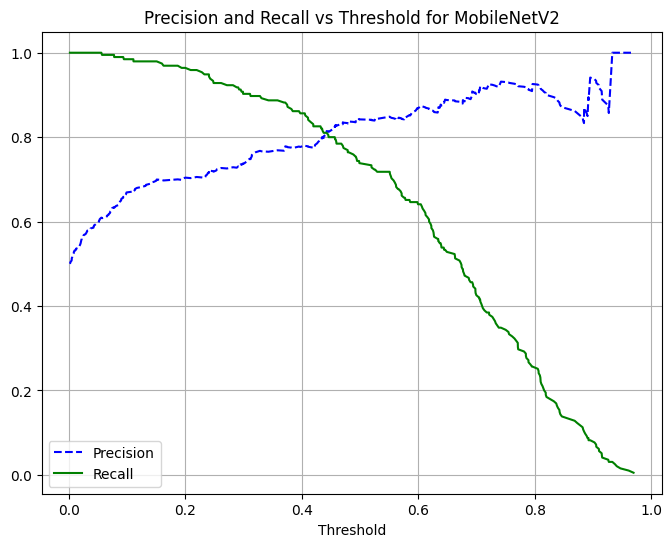

Model: MobileNetV2
Best F1 Score: 0.8274 at Threshold: 0.3279
Threshold for at least 90% Precision: 0.6923
13/13 ━━━━━━━━━━━━━━━━━━━━ 11s 801ms/step


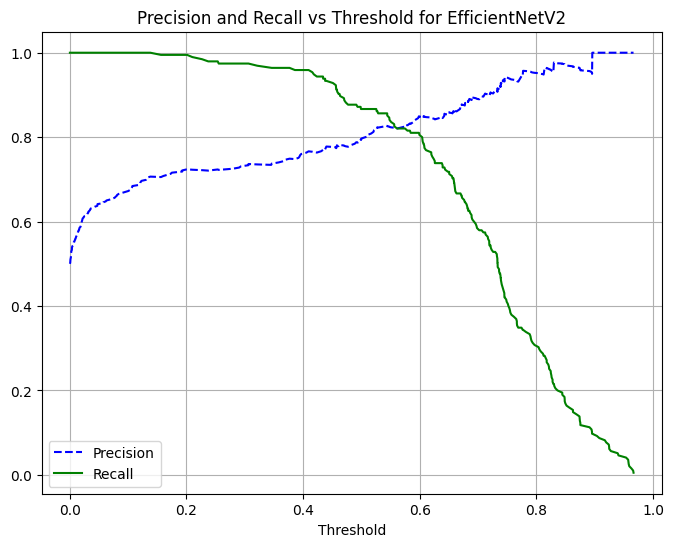

Model: EfficientNetV2
Best F1 Score: 0.8519 at Threshold: 0.4094
Threshold for at least 90% Precision: 0.7120
13/13 ━━━━━━━━━━━━━━━━━━━━ 10s 746ms/step


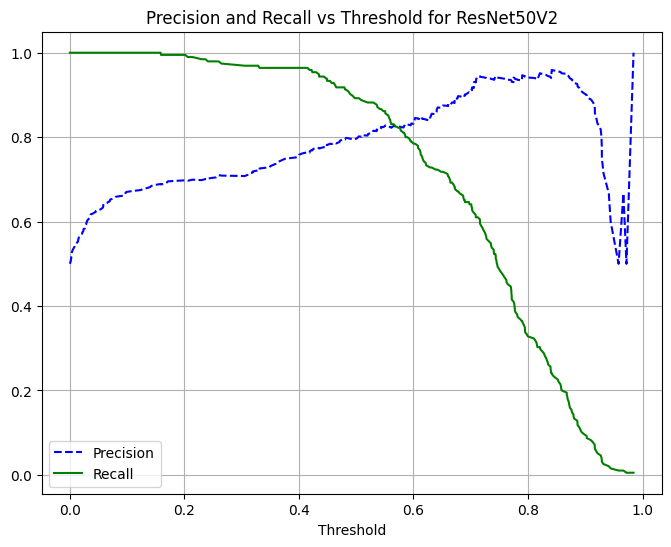

Model: ResNet50V2
Best F1 Score: 0.8552 at Threshold: 0.4302
Threshold for at least 90% Precision: 0.6896


In [21]:
from sklearn.metrics import precision_recall_curve, f1_score

def found_best_threshold(models:dict, dataset, min_precision=0.90):
    predicts = []
    for model_name, model in models.items():
        y_scores = model.predict(dataset['validation'])
        y_scores = np.asarray(y_scores).ravel()

        y_true = np.concatenate([y for x, y in dataset['validation']], axis=0)
        y_true = np.asarray(y_true).ravel().astype(int)

        precision, recall, thresholds = precision_recall_curve(y_true, y_scores)
        plot_precision_recall_vs_threshold(precision, recall, thresholds, model_name)
        get_best_threshold(precision, recall, thresholds, model_name, min_precision)

def plot_precision_recall_vs_threshold(precision, recall, thresholds, model_name):
    import matplotlib.pyplot as plt

    plt.figure(figsize=(8, 6))
    plt.plot(thresholds, precision[:-1], 'b--', label='Precision')
    plt.plot(thresholds, recall[:-1], 'g-', label='Recall')
    plt.xlabel('Threshold')
    plt.title(f'Precision and Recall vs Threshold for {model_name}')
    plt.legend()
    plt.grid()
    plt.show()

def get_best_threshold(precision, recall, thresholds, model_name, min_precision):
    f1_scores = 2 * (precision * recall) / (precision + recall)
    best_index_f1 = np.argmax(f1_scores)
    best_threshold_f1 = thresholds[best_index_f1]
    best_f1 = f1_scores[best_index_f1]

    idx_for_90_precision = (precision >= min_precision).argmax()
    threshold_for_90_precision = thresholds[idx_for_90_precision]
    print(f"Model: {model_name}")
    print(f"Best F1 Score: {best_f1:.4f} at Threshold: {best_threshold_f1:.4f}")
    print(f"Threshold for at least 90% Precision: {threshold_for_90_precision:.4f}")
    return threshold_for_90_precision

threshold_for_90_precision = found_best_threshold(models=models, dataset=dataset)

### Roc Auc Curve

"the ROC curve plots the true
positive rate (another name for recall) against the false positive rate (FPR)." that said the author from Hands on machine learning with Scikit-Learn, Keras, and TensorFlow book in chapter 3. The main idea is to evaluate the model in different thresholds and see how the model is behaving. The ROC is only used in binary classification problems.

13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 446ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 12s 913ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 10s 783ms/step


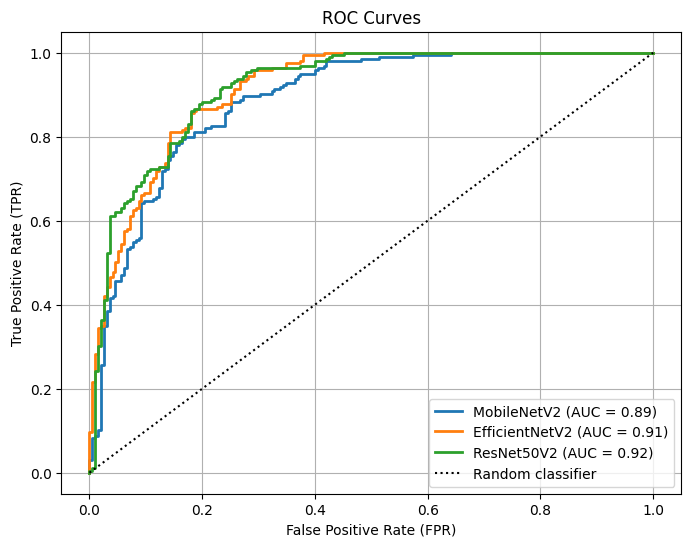

In [24]:
def plot_roc_curve(models: dict, dataset, threshold_for_90_precision=None):
    import matplotlib.pyplot as plt
    from sklearn.metrics import roc_curve, auc
    import numpy as np
    plt.figure(figsize=(8, 6))

    for model_name, model in models.items():
        y_scores = model.predict(dataset)
        y_scores = np.asarray(y_scores).ravel()
        y_true = np.concatenate([y for x, y in dataset], axis=0)

        fpr, tpr, thresholds = roc_curve(y_true, y_scores)
        roc_auc = auc(fpr, tpr)

        # ROC line for this model
        plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})', linewidth=2)

        # If a threshold is provided, find the closest threshold index and mark it
        if threshold_for_90_precision is not None and thresholds.size > 0:
            # thresholds are returned sorted from high to low; find closest
            idx = np.argmin(np.abs(thresholds - threshold_for_90_precision))
            plt.plot(fpr[idx], tpr[idx], 'o', label=f'{model_name} (thr={thresholds[idx]:.2f})', markersize=6)

    plt.plot([0, 1], [0, 1], 'k:', label="Random classifier")
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('ROC Curves')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

plot_roc_curve(models=models, dataset=dataset['validation'], threshold_for_90_precision=threshold_for_90_precision)

### Model Ensembling

In [14]:
from keras.models import load_model
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from typing import Dict, Optional

import numpy as np
import os
import joblib

mobilenet_model = load_model('model/saved_models/MobileNetV2Instance.keras')
efficiennet_model = load_model('model/saved_models/EfficientNetV2Instance.keras')
resnet_model = load_model('model/saved_models/ResNet50V2Instance.keras')

mobilenet_pred = mobilenet_model.predict(dataset['validation'])
efficiennet_pred = efficiennet_model.predict(dataset['validation'])
resnet_pred = resnet_model.predict(dataset['validation'])

X_meta_train = np.column_stack((mobilenet_pred, efficiennet_pred, resnet_pred))
y_meta_train = np.concatenate([y for x, y in dataset['validation']], axis=0)
y_meta_train = y_meta_train.ravel().astype(int)

models = {
    'DecisionTree': DecisionTreeClassifier(),
    'RandomForest': RandomForestClassifier(n_estimators=100),
    'GradientBoosting': GradientBoostingClassifier(n_estimators=100),
    'LogisticRegression': LogisticRegression()
}

def train_meta_model(X_meta_train, y_meta_train, models: Dict[str, object],
                     save_models: bool = False, save_dir: Optional[str] = None) -> Dict[str, object]:
    """
    Entrena los meta-modelos y devuelve un dict con los modelos ya entrenados.
    Opcionalmente guarda cada modelo en `save_dir` como archivo .joblib.
    """
    trained_models = {}

    if save_models and save_dir is None:
        raise ValueError("If save_models is True, save_dir must be provided.")

    if save_models:
        os.makedirs(save_dir, exist_ok=True)

    for name, model in models.items():
        print(f"Training meta-model for {name}")
        model.fit(X_meta_train, y_meta_train)

        y_meta_pred = model.predict(X_meta_train)
        print(f"Confusion Matrix for {name}:\n{confusion_matrix(y_meta_train, y_meta_pred)}")
        print(f"Classification Report for {name}:\n{classification_report(y_meta_train, y_meta_pred)}")
        accuracy = accuracy_score(y_meta_train, y_meta_pred)
        print(f"Accuracy for {name}: {accuracy:.4f}\n")

        trained_models[name] = model

        if save_models:
            filepath = os.path.join(save_dir, f"{name}.joblib")
            joblib.dump(model, filepath)
            print(f"Saved {name} to {filepath}")

    return trained_models

trained_meta_models = train_meta_model(
    X_meta_train,
    y_meta_train,
    models,
    save_models=True,
    save_dir='model/saved_models/meta_models'
)

print('Saved meta-models:', list(trained_meta_models.keys()))
print('Training and saving of meta-models completed successfully.')


13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 414ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 11s 775ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 11s 742ms/step
Training meta-model for DecisionTree
Confusion Matrix for DecisionTree:
[[195   0]
 [  0 195]]
Classification Report for DecisionTree:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       195
           1       1.00      1.00      1.00       195

    accuracy                           1.00       390
   macro avg       1.00      1.00      1.00       390
weighted avg       1.00      1.00      1.00       390

Accuracy for DecisionTree: 1.0000

Saved DecisionTree to model/saved_models/meta_models\DecisionTree.joblib
Training meta-model for RandomForest
Confusion Matrix for RandomForest:
[[195   0]
 [  0 195]]
Classification Report for RandomForest:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       195
           1       1.00      1.00      1.00       195

    ac

### Test the meta models in the test dataset

In [15]:
import os
import glob
import joblib
from typing import Dict

def load_joblib_model(filepath: str):
    """Carga un único modelo desde filepath (.joblib)."""
    try:
        return joblib.load(filepath)
    except Exception as e:
        print(f"Error cargando {filepath}: {e}")
        return None

def load_all_joblib_models(dir_path: str) -> Dict[str, object]:
    """Carga todos los .joblib en dir_path y devuelve un dict {nombre: modelo}."""
    models = {}
    pattern = os.path.join(dir_path, "*.joblib")
    for fpath in glob.glob(pattern):
        name = os.path.splitext(os.path.basename(fpath))[0]
        model = load_joblib_model(fpath)
        if model is not None:
            models[name] = model
    return models

# Uso:
# Cargar un modelo específico
#rf = load_joblib_model("model/saved_models/meta_models/RandomForest.joblib")

# Cargar todos los modelos de la carpeta

meta_models = load_all_joblib_models("model/saved_models/meta_models")


{'DecisionTree': DecisionTreeClassifier(), 'GradientBoosting': GradientBoostingClassifier(), 'LogisticRegression': LogisticRegression(), 'RandomForest': RandomForestClassifier()}


In [ ]:

mobilenet_model = load_model('model/saved_models/MobileNetV2Instance.keras')
efficiennet_model = load_model('model/saved_models/EfficientNetV2Instance.keras')
resnet_model = load_model('model/saved_models/ResNet50V2Instance.keras')

models = {
    'MobileNetV2': mobilenet_model,
    'EfficientNetV2': efficiennet_model,
    'ResNet50V2': resnet_model
}

def evaluate_meta_models(dataset, base_models: Dict[str, object], meta_models: Dict[str, object], threshold: float = 0.7):
    base_model_preds = []

    for model_name, model in base_models.items():
        y_scores = model.predict(dataset)
        y_scores = np.asarray(y_scores).ravel()
        base_model_preds.append(y_scores)

    # Crear matriz de características para los meta-modelos
    X_meta_test = np.column_stack(base_model_preds)
    y_true = np.concatenate([y for x, y in dataset], axis=0)
    y_true = y_true.ravel().astype(int)

    # Evaluar cada meta-modelo
    for model_name, meta_model in meta_models.items():
        print(f"Evaluating meta-model: {model_name}")
        y_meta_pred_proba = meta_model.predict(X_meta_test)
        y_meta_pred = (y_meta_pred_proba > threshold).astype(int)

        print(f"Confusion Matrix for {model_name}:\n{confusion_matrix(y_true, y_meta_pred)}")
        print(f"Classification Report for {model_name}:\n{classification_report(y_true, y_meta_pred)}")
        accuracy = accuracy_score(y_true, y_meta_pred)
        print(f"Accuracy for {model_name}: {accuracy:.4f}\n")

evaluate_meta_models(dataset=dataset['test'], base_models=models, meta_models=meta_models, threshold=0.7)

### K-Fold evaluation utilities for ensemble

In [23]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.base import clone
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, confusion_matrix, classification_report)
from typing import Dict, Callable, Tuple, Any


def dataset_to_numpy(dataset) -> Tuple[np.ndarray, np.ndarray]:
    """
    Convierte un tf.data.Dataset (ej: PrefetchDataset) a arrays numpy X, y.
    Devuelve X con shape (N, H, W, C) y y como vector (N,).
    Maneja batches y tensores en GPU/TPU (usa .numpy()).
    """
    X_parts = []
    y_parts = []
    for x_batch, y_batch in dataset:
        # For TF eager tensors, call .numpy(); if already numpy, pass through
        try:
            X_parts.append(x_batch.numpy())
        except Exception:
            X_parts.append(np.asarray(x_batch))
        try:
            y_parts.append(y_batch.numpy())
        except Exception:
            y_parts.append(np.asarray(y_batch))

    if not X_parts:
        return np.array([]), np.array([])

    X = np.concatenate(X_parts, axis=0)
    y = np.concatenate(y_parts, axis=0).ravel().astype(int)
    return X, y


def build_meta_features_from_numpy(base_models: Dict[str, Any], X: np.ndarray, batch_size: int = 32) -> np.ndarray:
    """
    Predice con cada modelo Keras sobre el array X (numpy) y devuelve X_meta columna-por-modelo.
    Se asume que cada modelo devuelve un score/probabilidad (shape (N,1) o (N,)).
    """
    preds = []
    for name, model in base_models.items():
        y_scores = model.predict(X, batch_size=batch_size)
        y_scores = np.asarray(y_scores).ravel()
        preds.append(y_scores)
    X_meta = np.column_stack(preds)
    return X_meta


def run_kfold_meta_ensemble(base_models: Dict[str, Any],
                            meta_model_constructors: Dict[str, Callable[[], Any]],
                            dataset,
                            n_splits: int = 5,
                            shuffle: bool = True,
                            random_state: int | None = None,
                            threshold: float = 0.5) -> Tuple[pd.DataFrame, Dict[str, pd.DataFrame]]:
    """
    Ejecuta K-Fold cross-validation para los meta-modelos.

    - base_models: dict de modelos Keras cargados {name: keras_model} (usados para generar features)
    - meta_model_constructors: dict {name: callable} que devuelve una nueva instancia del estimador sklearn
      (por ejemplo, {'RandomForest': lambda: RandomForestClassifier(n_estimators=100)})
    - dataset: tf.data.Dataset (ej: dataset['validation'] o dataset['train']) que se convertirá a numpy

    Retorna:
    - summary_df: DataFrame con medias y desviaciones (accuracy, precision, recall, f1, roc_auc) por meta-modelo
    - folds_details: dict{name: DataFrame} con métricas por fold
    """
    # 1) convertir dataset a numpy
    X, y = dataset_to_numpy(dataset)
    if X.size == 0:
        raise ValueError("El dataset está vacío o no se pudieron extraer tensores.")

    # 2) construir features meta (predicciones de los modelos base)
    X_meta = build_meta_features_from_numpy(base_models, X)

    # 3) preparar KFold
    kf = KFold(n_splits=n_splits, shuffle=shuffle, random_state=random_state)

    # 4) preparar contenedores para resultados
    summary_rows = []
    folds_details = {name: [] for name in meta_model_constructors.keys()}

    # 5) iterar por folds
    for fold_idx, (train_idx, val_idx) in enumerate(kf.split(X_meta)):
        print(f"\n--- Fold {fold_idx + 1}/{n_splits} ---")
        X_train, X_val = X_meta[train_idx], X_meta[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        for name, constructor in meta_model_constructors.items():
            # create fresh estimator per fold
            clf = constructor()
            try:
                clf.fit(X_train, y_train)
            except Exception as e:
                print(f"Error training {name} on fold {fold_idx}: {e}")
                continue

            # obtener probabilidades o scores
            proba = None
            try:
                if hasattr(clf, 'predict_proba'):
                    proba = clf.predict_proba(X_val)[:, 1]
                elif hasattr(clf, 'decision_function'):
                    proba = clf.decision_function(X_val)
                else:
                    # fallback a predict (etiquetas)
                    proba = clf.predict(X_val)
                    proba = np.asarray(proba).ravel()
            except Exception as e:
                print(f"Error obteniendo probabilidades con {name}: {e}")
                proba = clf.predict(X_val)
                proba = np.asarray(proba).ravel()

            y_pred = (proba > threshold).astype(int)

            # calcular métricas
            acc = accuracy_score(y_val, y_pred)
            prec = precision_score(y_val, y_pred, zero_division=0)
            rec = recall_score(y_val, y_pred, zero_division=0)
            f1 = f1_score(y_val, y_pred, zero_division=0)
            try:
                roc_auc = roc_auc_score(y_val, proba)
            except Exception:
                roc_auc = np.nan

            folds_details[name].append({
                'fold': fold_idx + 1,
                'accuracy': acc,
                'precision': prec,
                'recall': rec,
                'f1': f1,
                'roc_auc': roc_auc,
                'confusion_matrix': confusion_matrix(y_val, y_pred),
                'classification_report': classification_report(y_val, y_pred, zero_division=0)
            })

            print(f"Model: {name} | Fold: {fold_idx + 1} | Acc: {acc:.4f} | Prec: {prec:.4f} | Rec: {rec:.4f} | F1: {f1:.4f} | AUC: {roc_auc if not np.isnan(roc_auc) else 'N/A'}")

    # 6) resumir métricas por modelo
    for name, records in folds_details.items():
        if not records:
            continue
        df = pd.DataFrame(records)
        # calcular mean y std
        summary_rows.append({
            'Model': name,
            'accuracy_mean': df['accuracy'].mean(),
            'accuracy_std': df['accuracy'].std(),
            'precision_mean': df['precision'].mean(),
            'precision_std': df['precision'].std(),
            'recall_mean': df['recall'].mean(),
            'recall_std': df['recall'].std(),
            'f1_mean': df['f1'].mean(),
            'f1_std': df['f1'].std(),
            'roc_auc_mean': df['roc_auc'].mean(skipna=True),
            'roc_auc_std': df['roc_auc'].std(skipna=True),
            'folds': df
        })

        # replace list with DataFrame for external inspection
        folds_details[name] = df

    summary_df = pd.DataFrame(summary_rows).set_index('Model')
    print('\n=== K-Fold summary ===')
    print(summary_df)

    return summary_df, folds_details



### Ejemplo de uso

In [24]:
# Ejemplo: crear constructores para los meta-modelos (se usará uno nuevo por fold)
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression

meta_constructors = {
    'DecisionTree': lambda: DecisionTreeClassifier(),
    'RandomForest': lambda: RandomForestClassifier(n_estimators=100, random_state=42),
    'GradientBoosting': lambda: GradientBoostingClassifier(n_estimators=100),
    'LogisticRegression': lambda: LogisticRegression(max_iter=1000)
}

# Para ejecutar K-Fold sobre el conjunto de validación (por ejemplo):
summary, details = run_kfold_meta_ensemble(models, meta_constructors, dataset=dataset['validation'], n_splits=5)


13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 463ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 12s 857ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 12s 835ms/step

--- Fold 1/5 ---
Model: DecisionTree | Fold: 1 | Acc: 0.7692 | Prec: 0.6744 | Rec: 0.8788 | F1: 0.7632 | AUC: 0.7838383838383838
Model: RandomForest | Fold: 1 | Acc: 0.8333 | Prec: 0.7273 | Rec: 0.9697 | F1: 0.8312 | AUC: 0.8841750841750842
Model: GradientBoosting | Fold: 1 | Acc: 0.8333 | Prec: 0.7273 | Rec: 0.9697 | F1: 0.8312 | AUC: 0.9037037037037038
Model: LogisticRegression | Fold: 1 | Acc: 0.7692 | Prec: 0.6667 | Rec: 0.9091 | F1: 0.7692 | AUC: 0.9138047138047137

--- Fold 2/5 ---
Model: DecisionTree | Fold: 2 | Acc: 0.8333 | Prec: 0.7143 | Rec: 0.9677 | F1: 0.8219 | AUC: 0.8562113932738504
Model: RandomForest | Fold: 2 | Acc: 0.7949 | Prec: 0.6744 | Rec: 0.9355 | F1: 0.7838 | AUC: 0.8857240905971174
Model: GradientBoosting | Fold: 2 | Acc: 0.7949 | Prec: 0.6744 | Rec: 0.9355 | F1: 0.7838 | AUC: 0.9118050789293068
Model: LogisticRegression | Fold: 2 | Acc